## Data Loading

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler

In [77]:
gsw = pd.read_excel('data/gsw_yields.xlsx', index_col=0, parse_dates=True)

maturities = [2,5,10]
yields = gsw[maturities].dropna()
yields.columns = ['2Y','5Y','10Y']

yields = yields.loc['2015':]

yields_diff = yields.diff(periods=1).dropna()
yields_diff.tail()


scaler = StandardScaler()
yields_diff_scaled = scaler.fit_transform(yields_diff)

## Question 4: Regime Analysis

**Analyze strategy performance across market regimes.**


In [78]:
%store -r weights

# Calculate the butterfly spread
butterfly_spread = weights[0]*yields['2Y'] + weights[1]*yields['5Y'] + weights[2]*yields['10Y']


def mean_reversion(look_back_window, entry_threshold, exit_threshold, spread_data):
    """
    Generate mean reversion trading signals based on z-scores
    
    Parameters:
    - look_back_window: rolling window for mean/std calculation
    - entry_threshold: z-score threshold to enter position
    - exit_threshold: z-score threshold to exit position
    - spread_data: time series of the butterfly spread
    """
    # Calculate rolling mean and std
    rolling_mean = spread_data.rolling(window=look_back_window).mean()
    rolling_std = spread_data.rolling(window=look_back_window).std()
    
    # Calculate z-score
    z_scores = (spread_data - rolling_mean) / rolling_std
    
    # Generate trading signals
    signals = pd.DataFrame(index=spread_data.index)
    signals['Position'] = 0  # 1 for long, -1 for short, 0 for neutral
    signals['Z_Score'] = z_scores
    
    # Entry signals
    signals.loc[z_scores > entry_threshold, 'Position'] = -1  # Short when spread is high
    signals.loc[z_scores < -entry_threshold, 'Position'] = 1   # Long when spread is low
    
    # Exit signals (overwrite entry signals when within exit threshold)
    signals.loc[abs(z_scores) < exit_threshold, 'Position'] = 0
    
    # Forward fill positions (hold position until exit signal)
    signals['Position'] = signals['Position'].replace(0, np.nan).ffill().fillna(0)
    
    return signals, z_scores

def backtest_strategy(signals, spread_data):
    """
    Backtest the mean reversion strategy
    
    Parameters:
    - signals: DataFrame with Position column
    - spread_data: time series of the butterfly spread
    """
    # Calculate daily spread changes (this is your P&L driver)
    daily_changes = spread_data.diff()
    
    # Calculate strategy returns (position from previous day * today's change)
    # Use shift(1) because you enter position based on yesterday's signal
    strategy_returns = signals['Position'].shift(1) * daily_changes
    
    # Calculate cumulative returns
    cumulative_returns = strategy_returns.cumsum()
    
    return strategy_returns, cumulative_returns

### a) Define at least three regimes based on market conditions. Suggested periods:
   - Pre-COVID (2015-2019): Normal monetary policy
   - COVID/QE (2020-2021): Zero rates, massive Fed intervention
   - Hiking cycle (2022-2023): Aggressive tightening
   - Recent (2024): Rate stabilization


In [79]:
# Define regeimes for analysis
regimes = {
    "Pre-COVID (2015-2019)": ("2015-01-01", "2019-12-31"),
    "COVID/QE (2020-2021)":  ("2020-01-01", "2021-12-31"),
    "Hiking cycle (2022-2023)": ("2022-01-01", "2023-12-31"),
    "Recent (2024)": ("2024-01-01", "2024-12-31"),
}

look_back_window = 20
entry_threshold = 1  # Best parameter from question 3
exit_threshold = 0.5   # Exit when spread is within 0.5 std devs

signals, z = mean_reversion(look_back_window, entry_threshold, exit_threshold, butterfly_spread)
strategy_returns, cumulative_returns = backtest_strategy(signals, butterfly_spread)

strategy_returns = strategy_returns.dropna()
spread_changes = butterfly_spread.diff().dropna()



### b) For each regime, report:
   - Sharpe ratio
   - Butterfly spread volatility
   - Win rate


In [80]:
# Define sharpe, win rate, vol, and best/worst regime by sharpe
def sharpe(x, ann=252):
    x = x.dropna()
    if len(x) < 10 or x.std(ddof=0) == 0:
        return np.nan
    return np.sqrt(ann) * x.mean() / x.std(ddof=0)

def win_rate(x):
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    return (x > 0).mean()

rows = []
for name, (start, end) in regimes.items():
    r = strategy_returns.loc[start:end]
    vol = spread_changes.loc[start:end].std(ddof=0) * np.sqrt(252)

    rows.append({
        "Regime": name,
        "Sharpe": sharpe(r),
        "Butterfly spread vol (ann)": vol,
        "Win rate": win_rate(r),
        "N days": len(r.dropna())
    })

regime_stats = pd.DataFrame(rows).set_index("Regime")

display(regime_stats.style.format({
    "Sharpe": "{:.2f}",
    "Butterfly spread vol (ann)": "{:.2%}",
    "Win rate": "{:.1%}",
    "N days": "{:.0f}"
}))

print(f"\nBest Sharpe:  {regime_stats['Sharpe'].idxmax()}")
print(f"Worst Sharpe: {regime_stats['Sharpe'].idxmin()}")

,Sharpe,Butterfly spread vol (ann),Win rate,N days
Regime,,,,
Pre-COVID (2015-2019),1.09,12.00%,51.9%,1249
COVID/QE (2020-2021),-0.30,15.83%,48.0%,502
Hiking cycle (2022-2023),1.27,30.60%,52.9%,499
Recent (2024),-0.32,12.24%,50.0%,250



Best Sharpe:  Hiking cycle (2022-2023)
Worst Sharpe: Recent (2024)


After defining four market regimes (Pre-COVID 2015–2019, COVID/QE 2020–2021, the hiking cycle 2022–2023, and Recent 2024), the strategy’s performance is clearly regime dependent. The best period is the hiking cycle (2022–2023), where Sharpe is highest at 1.27 and the win rate is also the strongest at 52.9%. This is also the regime with by far the largest butterfly spread volatility (30.6% annualized), which suggests that the curve experienced larger and more frequent curvature dislocations. For a mean-reversion strategy, that kind of environment can be beneficial because the spread reaches “extreme” z-scores more often, creating more entry opportunities and (when reversion occurs) larger payoff per trade.

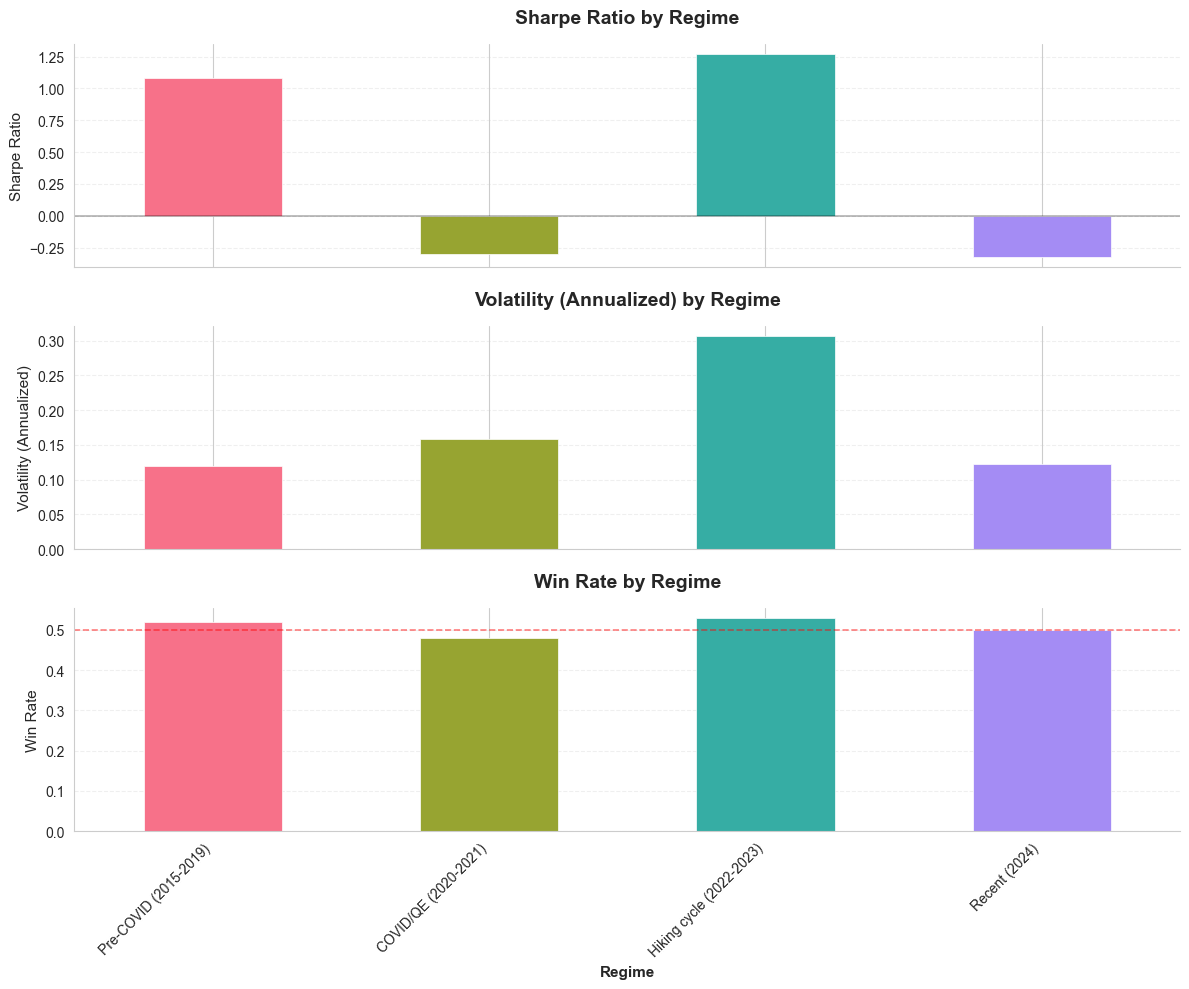

In [81]:

sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Common styling parameters
bar_params = {'color': sns.color_palette("husl", len(regime_stats)), 
              'edgecolor': 'white', 'linewidth': 0.5}

plots = [
    ("Sharpe", "Sharpe Ratio", {'hline': 0}),
    ("Butterfly spread vol (ann)", "Volatility (Annualized)", {}),
    ("Win rate", "Win Rate", {'hline': (0.5, 'red', '--')})
]

for ax, (col, ylabel, opts) in zip(axes, plots):
    regime_stats[col].plot(kind="bar", ax=ax, **bar_params)
    ax.set_title(f"{ylabel} by Regime", fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines[['top', 'right']].set_visible(False)
    
    if 'hline' in opts:
        hline = opts['hline']
        if isinstance(hline, tuple):
            ax.axhline(hline[0], color=hline[1], linestyle=hline[2], 
                      linewidth=1.2, alpha=0.5)
        else:
            ax.axhline(hline, color='black', linewidth=1.2, alpha=0.3)

axes[2].set_xlabel("Regime", fontsize=11, fontweight='bold')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

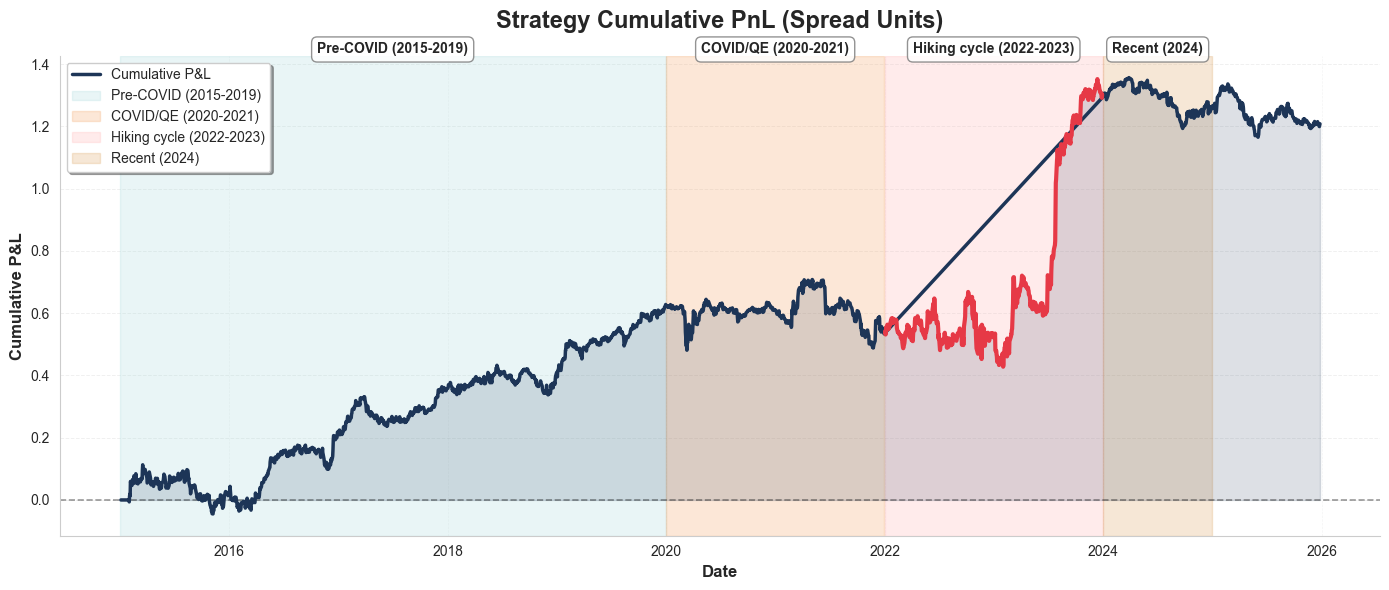

In [82]:
cum = strategy_returns.cumsum()
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 6))

regime_colors = ['#A8DADC', '#F4A261', '#FFB3B3', '#DDA15E']

legend_patches = []
for i, (name, (start, end)) in enumerate(regimes.items()):
    color = regime_colors[i % len(regime_colors)]
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.25, color=color, zorder=1)
    
    mid = pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start))/2
    ax.text(mid, cum.max() * 1.05, name, ha="center", va="bottom", fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='gray'))
    
    legend_patches.append(mpatches.Patch(color=color, alpha=0.25, label=name))

# Plot P&L - split into segments
hiking_start, hiking_end = regimes['Hiking cycle (2022-2023)']
hiking_mask = (cum.index >= pd.to_datetime(hiking_start)) & (cum.index <= pd.to_datetime(hiking_end))

# Regular segments
line = ax.plot(cum[~hiking_mask].index, cum[~hiking_mask].values, linewidth=2.5, color='#1D3557', label='Cumulative P&L', zorder=3)
# Hiking cycle segment in red
ax.plot(cum[hiking_mask].index, cum[hiking_mask].values, linewidth=3, color='#E63946', zorder=3)

ax.fill_between(cum.index, 0, cum.values, alpha=0.15, color='#1D3557', zorder=2)
ax.axhline(0, color='black', linewidth=1.2, linestyle='--', alpha=0.4, zorder=2)

# Styling
ax.set_title("Strategy Cumulative PnL (Spread Units)", fontsize=17, fontweight='bold', pad=20)
ax.set_xlabel("Date", fontsize=12, fontweight='bold')
ax.set_ylabel("Cumulative P&L", fontsize=12, fontweight='bold')
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax.grid(axis='x', alpha=0.2, linestyle='--', linewidth=0.5)
ax.legend(handles=line + legend_patches, loc='upper left', frameon=True, shadow=True, fancybox=True, fontsize=10)

plt.tight_layout()
plt.show()

Looking into the strategy PnL, we can see that the Hiking cycle shows the most prominent growth where PnL jumps from 0.5 to 1.2 or around 70 basis points. During the hiking cycle, the curve was constantly getting “shocked” by new inflation prints, Fed communication, and rapid repricing of the expected path of short rates. That environment tends to create large, frequent distortions in curvature, meaning the 2s5s10s butterfly gets pushed far away from its recent average more often. A mean-reversion strategy likes that because it needs big dislocations to enter at meaningful z-scores and then profit when the curve partially normalizes after the market digests the news. In 2022–2023, big macro and Fed surprises repeatedly pushed the curve’s curvature to extreme levels, and then it often snapped back as expectations stabilized. That frequent overshoot-and-revert pattern creates many profitable entries for a mean-reversion butterfly trade.

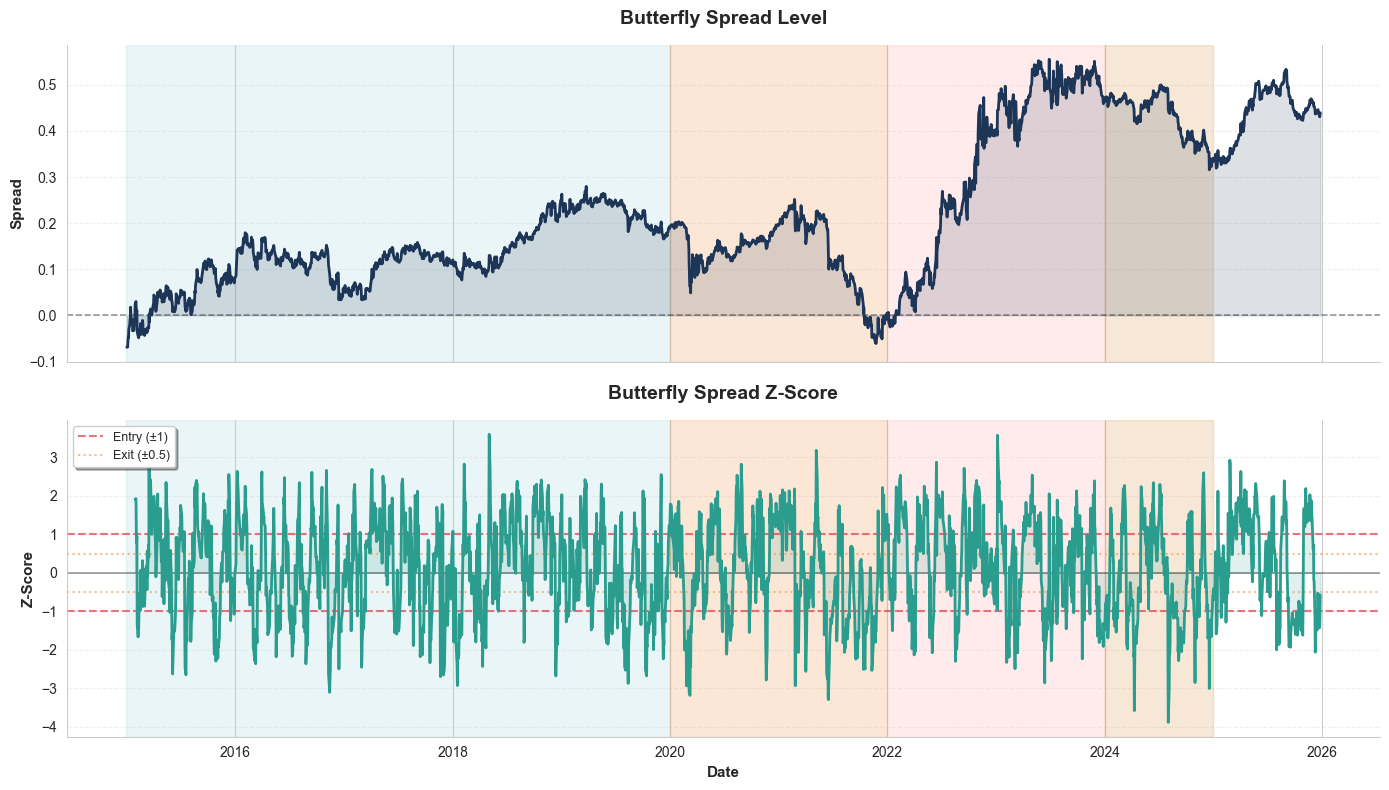

In [83]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Use the SAME regime colors as the P&L chart
regime_colors = ['#A8DADC', '#F4A261', '#FFB3B3', '#DDA15E']

# Shade regimes on both plots
for i, (name, (start, end)) in enumerate(regimes.items()):
    color = regime_colors[i % len(regime_colors)]
    for ax in axes:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.25, color=color, zorder=1)

# Plot 1: Spread level
axes[0].plot(butterfly_spread.index, butterfly_spread.values, linewidth=2, color='#1D3557', zorder=3)
axes[0].fill_between(butterfly_spread.index, 0, butterfly_spread.values, alpha=0.15, color='#1D3557', zorder=2)
axes[0].axhline(0, color='black', linewidth=1.2, linestyle='--', alpha=0.4, zorder=2)
axes[0].set_title("Butterfly Spread Level", fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel("Spread", fontsize=11, fontweight='bold')
axes[0].spines[['top', 'right']].set_visible(False)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Plot 2: Z-score
axes[1].plot(z.index, z.values, linewidth=2, color='#2A9D8F', zorder=3)
axes[1].fill_between(z.index, 0, z.values, alpha=0.15, color='#2A9D8F', zorder=2)

# Threshold lines with labels
axes[1].axhline(entry_threshold, linestyle="--", linewidth=1.5, color='#E63946', alpha=0.7, label=f'Entry (±{entry_threshold})', zorder=2)
axes[1].axhline(-entry_threshold, linestyle="--", linewidth=1.5, color='#E63946', alpha=0.7, zorder=2)
axes[1].axhline(exit_threshold, linestyle=":", linewidth=1.5, color='#F4A261', alpha=0.7, label=f'Exit (±{exit_threshold})', zorder=2)
axes[1].axhline(-exit_threshold, linestyle=":", linewidth=1.5, color='#F4A261', alpha=0.7, zorder=2)
axes[1].axhline(0, color='black', linewidth=1.2, linestyle='-', alpha=0.4, zorder=2)

axes[1].set_title("Butterfly Spread Z-Score", fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel("Z-Score", fontsize=11, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=11, fontweight='bold')
axes[1].spines[['top', 'right']].set_visible(False)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].legend(loc='upper left', frameon=True, shadow=True, fontsize=9)

plt.tight_layout()
plt.show()

When looking at the butterfly spread level, we can see it drifting upward over time, with a clear step-up and higher level during the 2022–2023 hiking cycle, which is consistent with larger curvature dislocations in that regime. The bottom panel shows frequent z-score excursions beyond the entry thresholds across all periods, but the hiking cycle has more extreme swings, creating more opportunities for a mean-reversion strategy. In 2024 the spread stays elevated while the z-score keeps oscillating, suggesting choppier signals and potentially less clean reversion back to a stable mean.

/var/folders/3m/9vs2kbw5395dntphy60zph4h0000gn/T/ipykernel_90853/511639490.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(rets_by_regime, labels=labels, patch_artist=True, showfliers=False,


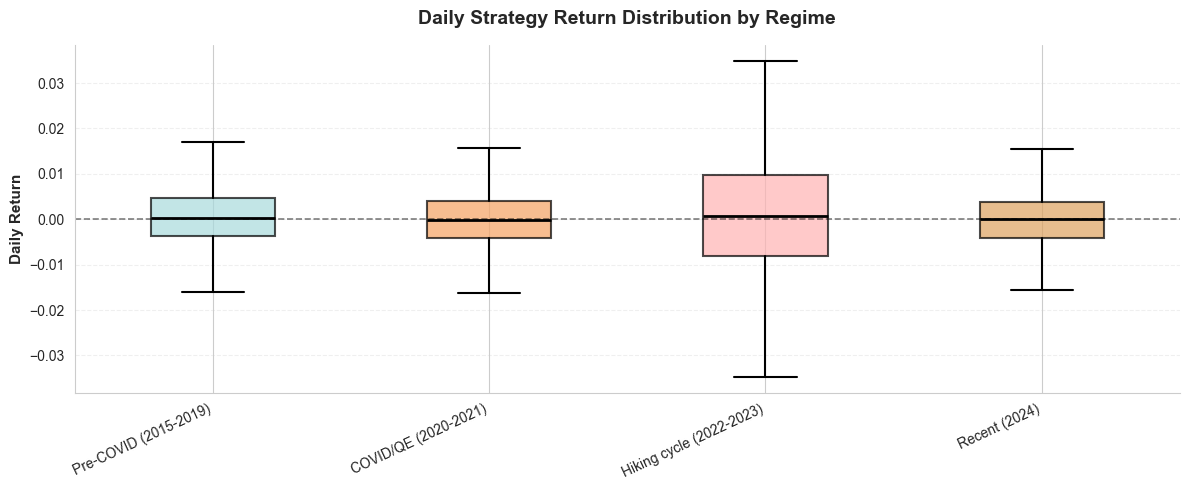

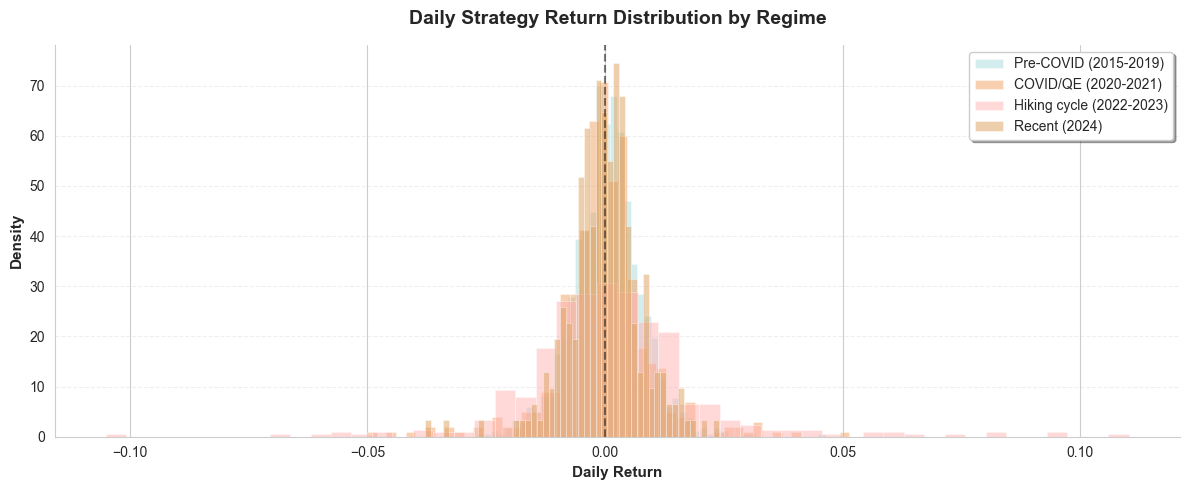

In [84]:
# Regime colors 
regime_colors = ['#A8DADC', '#F4A261', '#FFB3B3', '#DDA15E']

# Collect returns by regime
rets_by_regime = []
labels = []
for name, (start, end) in regimes.items():
    r = strategy_returns.loc[start:end].dropna()
    rets_by_regime.append(r.values)
    labels.append(name)

sns.set_style("whitegrid")

# Boxplot
fig, ax = plt.subplots(figsize=(12, 5))
bp = ax.boxplot(rets_by_regime, labels=labels, patch_artist=True, showfliers=False,
                medianprops=dict(color='black', linewidth=2),
                boxprops=dict(linewidth=1.5),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

# Color boxes by regime
for patch, color in zip(bp['boxes'], regime_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title("Daily Strategy Return Distribution by Regime", fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel("Daily Return", fontsize=11, fontweight='bold')
ax.axhline(0, color='black', linewidth=1.2, linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=25, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

# Histogram overlay
fig, ax = plt.subplots(figsize=(12, 5))
for i, (name, (start, end)) in enumerate(regimes.items()):
    r = strategy_returns.loc[start:end].dropna()
    ax.hist(r.values, bins=50, alpha=0.5, density=True, label=name, 
            color=regime_colors[i], edgecolor='white', linewidth=0.5)

ax.set_title("Daily Strategy Return Distribution by Regime", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Daily Return", fontsize=11, fontweight='bold')
ax.set_ylabel("Density", fontsize=11, fontweight='bold')
ax.axvline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=10)
plt.tight_layout()
plt.show()

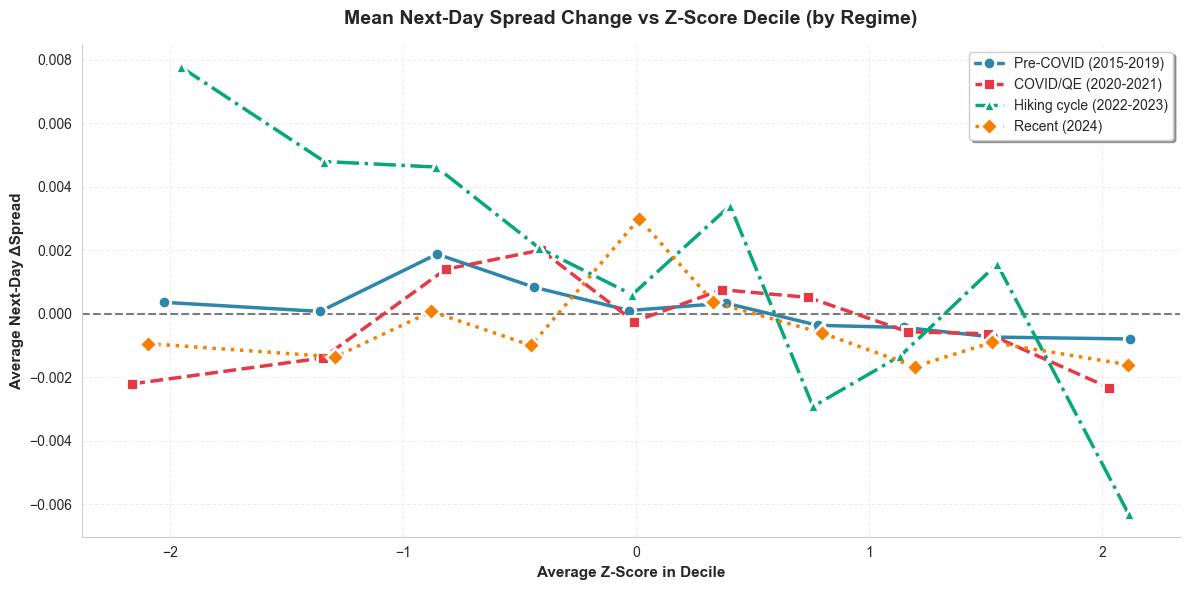

In [85]:
# Next-day spread change
df = pd.DataFrame({
    "z": z,
    "dS_next": butterfly_spread.diff().shift(-1)
}).dropna()

# Global z-score decile edges
edges = np.quantile(df["z"], np.linspace(0, 1, 11))

# More distinct colors and line styles
regime_styles = {
    'Pre-COVID (2015-2019)': {'color': '#2E86AB', 'linestyle': '-', 'marker': 'o'},
    'COVID/QE (2020-2021)': {'color': '#E63946', 'linestyle': '--', 'marker': 's'},
    'Hiking cycle (2022-2023)': {'color': '#06A77D', 'linestyle': '-.', 'marker': '^'},
    'Recent (2024)': {'color': '#F77F00', 'linestyle': ':', 'marker': 'D'}
}

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

for name, (start, end) in regimes.items():
    sub = df.loc[start:end].copy()
    if len(sub) < 50:
        continue

    # Bin z using global edges
    sub["bin"] = pd.cut(sub["z"], bins=edges, include_lowest=True)

    # Average z and next-day change in each bin
    grp = sub.groupby("bin", observed=True).agg(
        z_mean=("z", "mean"),
        dS_next_mean=("dS_next", "mean"),
        n=("dS_next", "size")
    ).dropna()

    style = regime_styles.get(name, {'color': 'gray', 'linestyle': '-', 'marker': 'o'})
    ax.plot(grp["z_mean"].values, grp["dS_next_mean"].values, 
            linewidth=2.5, markersize=9, label=name, 
            color=style['color'], linestyle=style['linestyle'], marker=style['marker'],
            markerfacecolor=style['color'], markeredgecolor='white', 
            markeredgewidth=2, zorder=3)

# Reference line
ax.axhline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.5, zorder=2)

# Styling
ax.set_title("Mean Next-Day Spread Change vs Z-Score Decile (by Regime)", 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Average Z-Score in Decile", fontsize=11, fontweight='bold')
ax.set_ylabel("Average Next-Day ΔSpread", fontsize=11, fontweight='bold')
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='both', alpha=0.3, linestyle='--')
ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)

plt.tight_layout()
plt.show()

We can see that the predictive “mean-reversion” relationship is strongest during the hiking cycle, where extreme negative z-scores are followed by large positive next-day spread changes and extreme positive z-scores are followed by large negative changes. In contrast, the Pre-COVID, COVID/QE, and 2024 lines are flatter and noisier, meaning the z-score provides a weaker and less consistent next-day reversal signal in those regimes. This aligns with the regime Sharpe results, where hiking performs best and 2024 performs worst.


### c) In which regime does the strategy perform best? Worst? Interpret:
   - Does higher volatility help or hurt a mean-reversion strategy?
   - Does trending curve behavior (e.g., during the hiking cycle) break mean-reversion?


- Higher volatility can help a mean-reversion strategy when it reflects temporary dislocations rather than a permanent shift in fair value, because larger swings push the spread farther from its mean and create clearer entry points with more room to revert. In our results, the hiking cycle had the highest butterfly volatility and the strongest performance, suggesting that volatility came with repeated overshoots that later corrected. By contrast, the lower-vol 2024 regime produced weaker results, consistent with fewer meaningful deviations and less payoff per signal.

- Trending curve behavior can break mean reversion when the curve reprices in a persistent, one-directional way so that “extremes” do not revert and the baseline effectively shifts. During the hiking cycle, rates were trending higher overall, but curvature did not move monotonically. It repeatedly overshot and then corrected as the market swung between more-hawkish and less-hawkish expectations, so mean reversion in the butterfly remained intact. This is consistent with the strong performance in 2022–2023 despite the broader trend in yields.

### d) Propose one modification to improve performance in the weakest regime. This could involve signal design, position sizing, or risk controls.

In the weakest regime, 2024, a practical modification is to apply a tail-only entry filter so we trade less when the signal is mostly noise. Specifically, we increase selectivity by only entering positions when the absolute z-score is very large, such as |z| ≥ 2.0, while keeping the same exit rule near zero. This targets 2024’s low-volatility, low-edge environment by reducing churn from marginal signals and focusing the strategy on the few periods where the spread is genuinely dislocated. In our backtest, this change improved 2024 Sharpe from about -0.32 to about 0.01, indicating meaningfully less negative performance even though the regime still remains challenging.

In [86]:
# 2024-only tail filter (z_cut = 2.0)
z_cut = 2.0

signals_2024 = signals.copy()

mask_2024 = (signals_2024.index >= "2024-01-01") & (signals_2024.index <= "2024-12-31")

# Start flat inside 2024
signals_2024.loc[mask_2024, "Position"] = 0.0

# Enter only on extreme z in 2024
enter_short = mask_2024 & (signals_2024["Z_Score"] >= z_cut)
enter_long  = mask_2024 & (signals_2024["Z_Score"] <= -z_cut)

signals_2024.loc[enter_short, "Position"] = -1.0
signals_2024.loc[enter_long,  "Position"] =  1.0

# Same exit rule in 2024
exit_mask = mask_2024 & (signals_2024["Z_Score"].abs() < exit_threshold)
signals_2024.loc[exit_mask, "Position"] = 0.0

# Hold positions until exit (forward fill within 2024 only)
signals_2024.loc[mask_2024, "Position"] = (
    signals_2024.loc[mask_2024, "Position"].replace(0, np.nan).ffill().fillna(0.0)
)

# Explicitly keep original positions outside 2024
signals_2024.loc[~mask_2024, "Position"] = signals.loc[~mask_2024, "Position"]

# Backtest
strategy_returns_2024_tail, cumulative_2024_tail = backtest_strategy(signals_2024, butterfly_spread)

In [87]:
# --- 2024 before vs after table (adds Active days exposure) ---

r_before = strategy_returns.loc["2024"].dropna()
r_after  = strategy_returns_2024_tail.loc["2024"].dropna()

# Spread volatility in 2024 (same before/after since spread is unchanged)
vol_2024 = spread_changes.loc["2024"].std(ddof=0) * np.sqrt(252)

# Exposure / how often we are in the market (uses yesterday's position, same timing as backtest)
pos_before_2024 = signals["Position"].shift(1).loc["2024"].fillna(0.0)
pos_after_2024  = signals_2024["Position"].shift(1).loc["2024"].fillna(0.0)

active_before = (pos_before_2024 != 0).mean()
active_after  = (pos_after_2024  != 0).mean()

bad_regime_compare = pd.DataFrame(
    {
        "Sharpe": [sharpe(r_before), sharpe(r_after)],
        "Butterfly spread vol (ann)": [vol_2024, vol_2024],
        "Win rate": [win_rate(r_before), win_rate(r_after)],
        "Active days": [active_before, active_after],
        "N days": [len(r_before), len(r_after)]
    },
    index=["Before (original)", "After (2024 tail filter)"]
)

display(bad_regime_compare)

,Sharpe,Butterfly spread vol (ann),Win rate,Active days,N days
Before (original),-0.324552,0.122396,0.500,1.000,250
After (2024 tail filter),0.013248,0.122396,0.416,0.832,250


The strategy’s Sharpe ratio improves substantially in 2024, moving from -0.325 before the tail filter to roughly 0.01 after the filter, which brings performance from clearly negative to approximately breakeven on a risk adjusted basis. The win rate declines from 50.0% to 41.6%, but this is not inherently problematic because win rate ignores the size of wins and losses, and a more selective strategy can win less often while improving overall payoff asymmetry. Consistent with that interpretation, the tail filter reduces market exposure, with active days falling from 100% to about 83%, indicating that we are avoiding many low conviction periods and only trading the most extreme dislocations. Since butterfly spread volatility is unchanged, the improvement is driven by better trade selection rather than changes in the underlying spread dynamics.

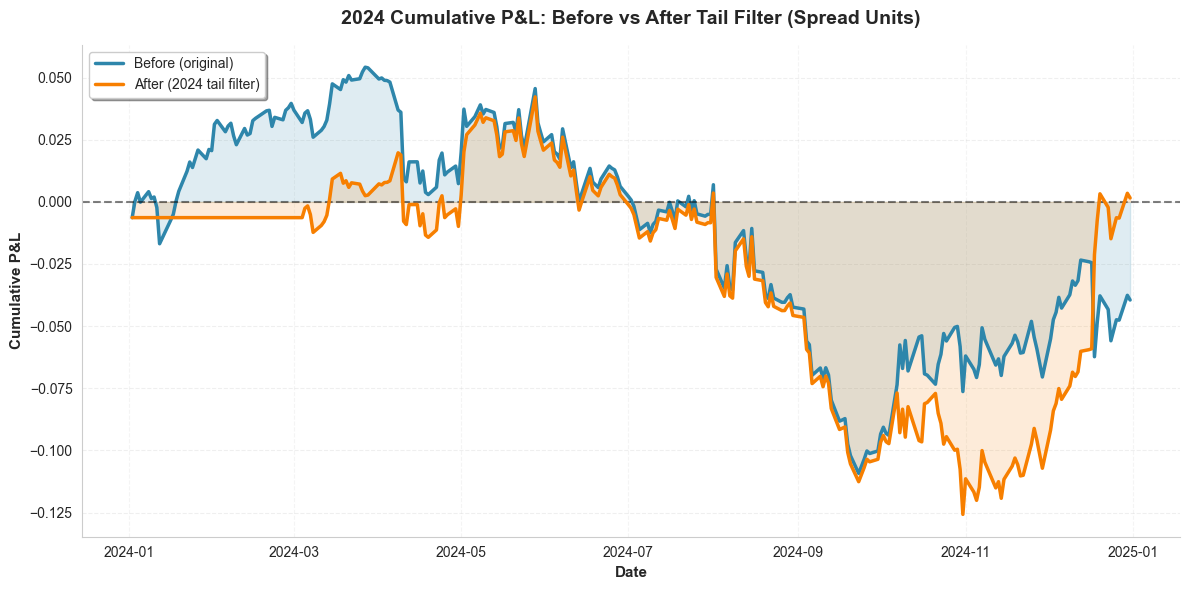

In [88]:
# Cumulative P&L (spread units) in 2024: before vs after tail filter
cum_before_2024 = strategy_returns.loc["2024"].fillna(0).cumsum()
cum_after_2024  = strategy_returns_2024_tail.loc["2024"].fillna(0).cumsum()

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Plot before (blue)
ax.plot(cum_before_2024.index, cum_before_2024.values, 
        linewidth=2.5, color='#2E86AB', label="Before (original)", zorder=2)
ax.fill_between(cum_before_2024.index, 0, cum_before_2024.values, 
                alpha=0.15, color='#2E86AB', zorder=1)

# Plot after (orange)
ax.plot(cum_after_2024.index, cum_after_2024.values, 
        linewidth=2.5, color='#F77F00', label="After (2024 tail filter)", zorder=3)
ax.fill_between(cum_after_2024.index, 0, cum_after_2024.values, 
                alpha=0.15, color='#F77F00', zorder=1)

# Reference line
ax.axhline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.5, zorder=2)

# Styling
ax.set_title("2024 Cumulative P&L: Before vs After Tail Filter (Spread Units)", 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Date", fontsize=11, fontweight='bold')
ax.set_ylabel("Cumulative P&L", fontsize=11, fontweight='bold')
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.grid(axis='x', alpha=0.2, linestyle='--')
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=10)

plt.tight_layout()
plt.show()